## Test technique
Arnal Svetlana

In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Analyse de dataset

In [2]:
df = pd.read_csv('dataset.csv', sep=',')
df.head()

,height,width,depth,weight,activity
0,90.5,42.0,2.0,1.25,mlp
1,60.0,50.0,2.0,1.20,mlp
2,80.0,59.6,2.0,7.40,mlp
3,46.0,46.0,2.0,1.45,mlp
4,93.0,21.0,2.0,1.30,mlp


In [3]:
print (f"{df.shape[0]} lignes {df.shape[1]} colonnes")

900 lignes 5 colonnes


Nettoyage des valeurs nulls et doubons 

In [4]:
print (f"{df.isna().sum().sum()} valeurs nulls")

0 valeurs nulls


In [5]:
print (f"Il y a {df[df.duplicated()].shape[0]} doublons in the dataframe")

Il y a 18 doublons in the dataframe


In [6]:
df[df.duplicated()].head()

,height,width,depth,weight,activity
46,31.0,45.0,4.0,1.1,mlp
53,31.0,45.0,4.0,1.1,mlp
256,42.0,35.0,35.0,4.1,mlp
659,76.0,50.0,50.0,5.5,meuble
662,50.0,52.0,52.0,5.0,meuble


In [7]:
df = df.drop_duplicates(keep = 'first', ignore_index=True)

Verification s'il y a des articles avec les mêmes charactéristiques dans les classes différentes  

In [8]:
df[df.duplicated(subset=['height', 'width', 'depth', 'weight'], keep=False)]

,height,width,depth,weight,activity


### 2. Analyse des valeurs

In [9]:
%matplotlib inline

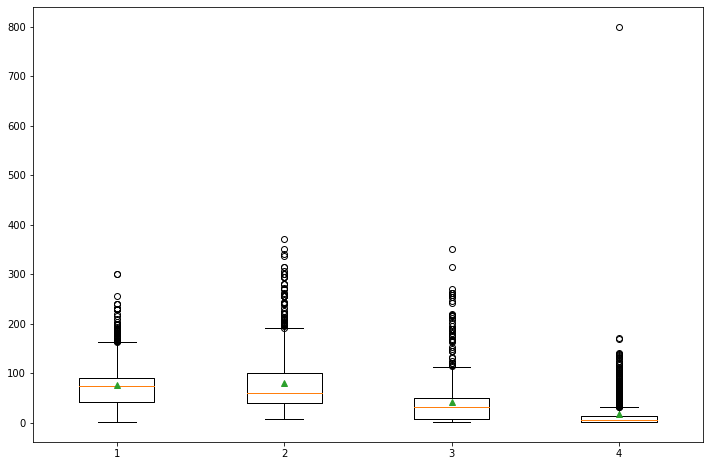

In [10]:
plt.figure(figsize=(12, 8))
plt.boxplot(df[['height', 'width', 'depth', 'weight']], showmeans=True)
plt.show()

On voit qu'il y a des valeurs aberrantes

In [11]:
df.loc[df['height']>250]

,height,width,depth,weight,activity
300,300.0,80.0,2.0,6.65,deco
308,300.0,200.0,2.0,15.50,deco
881,255.0,350.0,350.0,8.00,meuble


In [12]:
df.loc[df['width']>300]

,height,width,depth,weight,activity
732,82.0,336.0,105.0,94.0,meuble
835,76.0,341.0,220.0,111.4,meuble
842,86.0,315.0,253.0,171.0,meuble
843,86.0,315.0,253.0,35.0,meuble
844,85.0,370.0,315.0,137.5,meuble
873,82.0,306.0,190.0,110.0,meuble
881,255.0,350.0,350.0,8.0,meuble


In [13]:
df.loc[df['depth']>300]

,height,width,depth,weight,activity
844,85.0,370.0,315.0,137.5,meuble
881,255.0,350.0,350.0,8.0,meuble


In [14]:
df.loc[df['weight']>150]

,height,width,depth,weight,activity
133,13.5,30.0,20.0,800.0,mlp
789,220.0,210.0,49.0,168.0,meuble
842,86.0,315.0,253.0,171.0,meuble


On enleve que 2 lignes les plus étranges, le reste semble théoriquement possible (pour un dataset de testing)

In [15]:
df = df.drop(133)
df = df.drop(881)

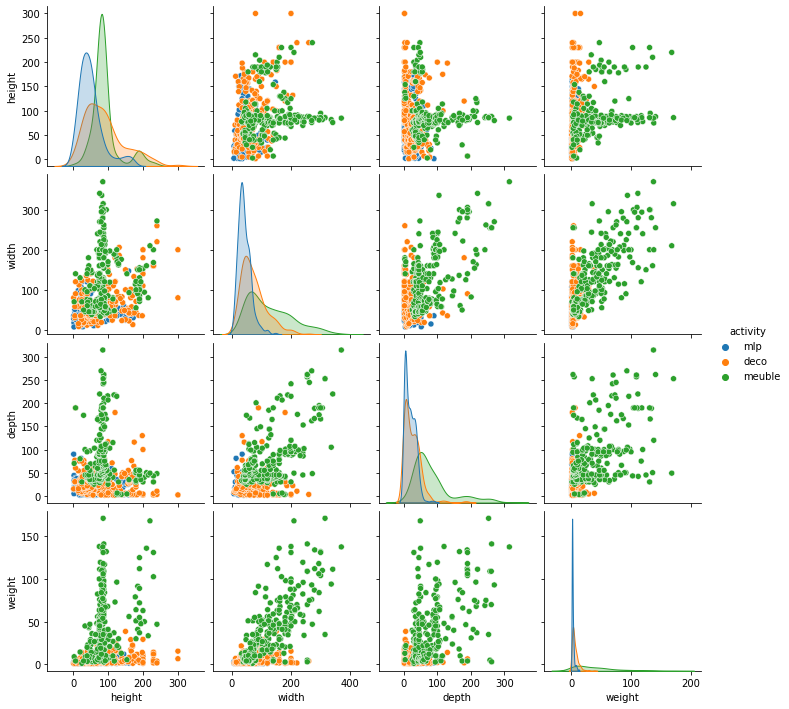

In [16]:
sns.pairplot(df, vars = ['height', 'width', 'depth', 'weight'], hue='activity')

La largeur et la profondeur semblent correlées, on verifie :

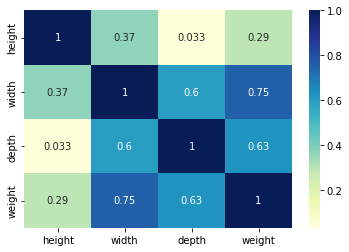

In [17]:
means =df[['height', 'width', 'depth', 'weight']]
_=sns.heatmap(means.corr(), annot = True, cmap="YlGnBu")

On peut remplacer la largeur et la profondeur par la diagonale pour pouvoir regarder la distribution des données en 3D:

In [18]:
df['diagonal'] =  np.sqrt((df.width)*(df.width)+(df.depth)*(df.depth))

In [19]:
df.tail()

,height,width,depth,weight,activity,diagonal
876,85.0,279.0,167.0,87.0,meuble,325.161498
877,81.0,295.0,175.0,84.0,meuble,343.001458
878,100.0,170.0,207.0,41.0,meuble,267.860038
879,125.0,200.0,215.0,96.3,meuble,293.640937
880,80.0,270.0,270.0,93.0,meuble,381.837662


Création de colonne cible numérique

In [20]:
df['category'] = 0
df.loc[df["activity"]=='deco','category']=1
df.loc[df["activity"]=='mlp','category']=2

In [21]:
df.activity.value_counts()

deco      300
mlp       296
meuble    284
Name: activity, dtype: int64

In [22]:
df.category.value_counts()

1    300
2    296
0    284
Name: category, dtype: int64

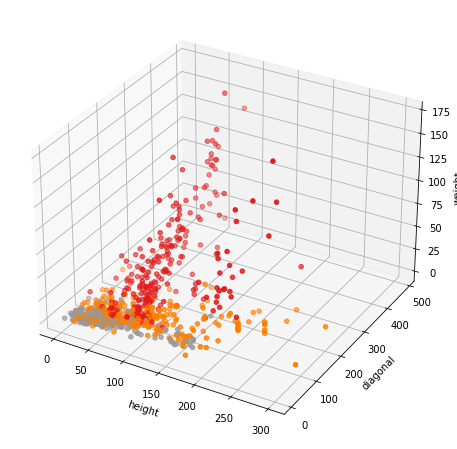

In [23]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(df['height'],df['diagonal'],df['weight'], c = df['category'], cmap="Set1")

ax.set_xlabel('height')
ax.set_ylabel('diagonal')
ax.set_zlabel('weight')

plt.show()

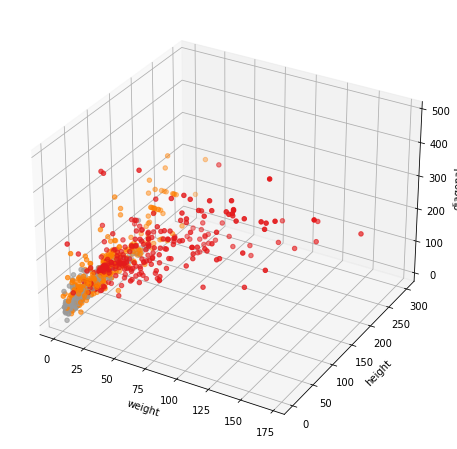

In [24]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(df['weight'],df['height'],df['diagonal'], c = df['category'], cmap="Set1")

ax.set_xlabel('weight')
ax.set_ylabel('height')
ax.set_zlabel('diagonal')

plt.show()

On constate qu'une categorie des produits (meubles) et mieux séparée, et les deux autres sont plus mélangées, donc la classification sera plus difficile. 
On verifie sur les boites à moustage par catégorie :

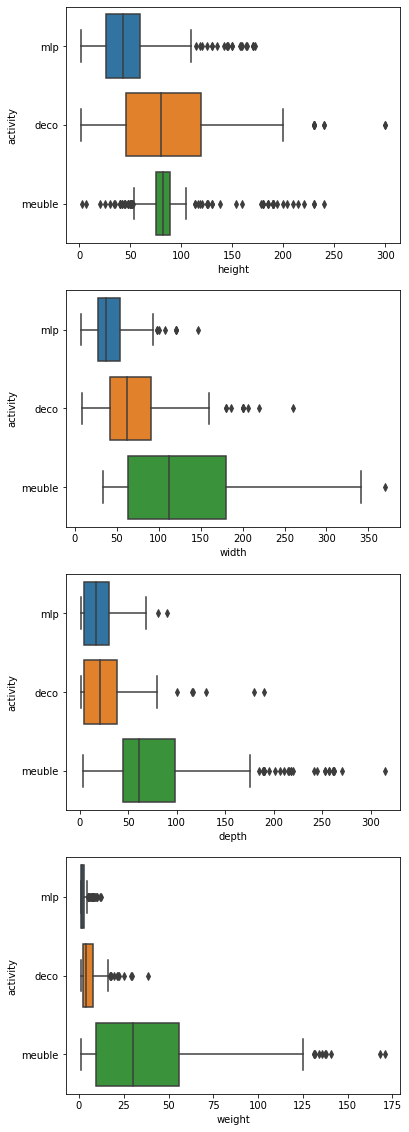

In [25]:
fig = plt.subplots(ncols=1, nrows = 4, figsize = (6,20))

plt.subplot(4,1,1)
sns.boxplot(x='height',y='activity',data=df)

plt.subplot(4,1,2)
sns.boxplot(x='width',y='activity',data=df)

plt.subplot(4,1,3)
sns.boxplot(x='depth',y='activity',data=df)

plt.subplot(4,1,4)
sns.boxplot(x='weight',y='activity',data=df)
plt.show()

On voit également que les catégories "deco" et "mlp" sont très proches

### 3. Machine learning

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score


In [27]:
X, y = df[['height', 'width', 'depth', 'weight']], df.category
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

#### k-Nearest Neighbours

In [28]:
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_jobs=-1))]
)

knn_params = {"knn__n_neighbors": range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(X_train, y_train)

knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


({'knn__n_neighbors': 1}, 0.8035798583792289)

In [29]:
accuracy_score(y_test, knn_grid.predict(X_test)) 

0.75

#### Decision Trees

In [30]:
tree = DecisionTreeClassifier()

tree_params = {"max_depth": range(1, 11), "max_features": range(2, 4)}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

tree_grid.best_params_, tree_grid.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


({'max_depth': 7, 'max_features': 2}, 0.7759900340938893)

In [31]:
accuracy_score(y_test, tree_grid.predict(X_test)) 

0.7878787878787878

#### Random Forest

In [32]:
forest = RandomForestClassifier()

forest_params = {"max_depth": range(3, 12), "max_features": range(2, 4)}

forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)

forest_grid.fit(X_train, y_train)

forest_grid.best_params_, forest_grid.best_score_ 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


({'max_depth': 11, 'max_features': 2}, 0.8360870705481249)

In [33]:
accuracy_score(y_test, forest_grid.predict(X_test)) 

0.8106060606060606

On constate que les 3 algorithmes donnent les résultats similaires avec la precision (accuracy) assez faible. 

Maintenant on va les tester sur la catégorie "meuble" one-vs-rest :


In [34]:
df['flag_meuble'] = 0
df.loc[df["activity"]=='meuble','flag_meuble']=1

In [35]:
X, y = df[['height', 'width', 'depth', 'weight']], df.flag_meuble
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

In [36]:
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_jobs=-1))]
)

knn_params = {"knn__n_neighbors": range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(X_train, y_train)

knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


({'knn__n_neighbors': 6}, 0.9399029635457644)

In [37]:
accuracy_score(y_test, knn_grid.predict(X_test)) 

0.9507575757575758

In [38]:
tree = DecisionTreeClassifier()

tree_params = {"max_depth": range(1, 11), "max_features": range(2, 4)}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

tree_grid.best_params_, tree_grid.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


({'max_depth': 6, 'max_features': 3}, 0.9204301075268816)

In [39]:
accuracy_score(y_test, tree_grid.predict(X_test)) 

0.9053030303030303

In [40]:
forest = RandomForestClassifier()

forest_params = {"max_depth": range(3, 12), "max_features": range(2, 4)}

forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)

forest_grid.fit(X_train, y_train)

forest_grid.best_params_, forest_grid.best_score_ 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


({'max_depth': 7, 'max_features': 3}, 0.9366509310254394)

In [41]:
accuracy_score(y_test, forest_grid.predict(X_test)) 

0.9659090909090909

On voit que les résultats sont beaucoup plus précis.

Conclusion: c'est possible de catégoriser les données avec accuracy vers 0.8, on peut classifier les objets comme "meuble" avec accuracy plus élevée (vers 0.94), pour les deux autres catégories un traitement supplementaire setait recommandé.